In [1]:
import lapgm
import view_utils
import brainweb_utils

import matplotlib.pyplot as plt

# Data Acquisition
We will be using the *BrainWeb* dataset for our debiasing example. Example data will be downloaded once into the examples/data subfolder.

In [2]:
# Select a low noise, high RF intensity preset from the BrainWeb normal dataset
brainweb_dict = brainweb_utils.download_and_read_normal(noise=1, rf_intensity=40)

brainweb_data = [brainweb_dict['T1'], brainweb_dict['T2'], brainweb_dict['PD']]

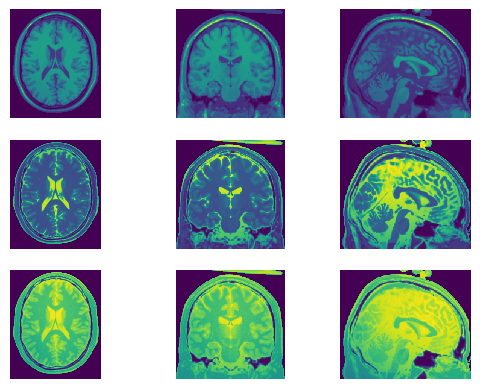

In [49]:
# Associated label data
class_data = brainweb_utils.download_and_read_phantom()
data_mask = class_data > 0

# View center slices of the BrainWeb dataset
view_utils.view_center_slices(brainweb_data, data_mask, color_scale=True)

# Debias Setup and Run
LapGM can be run either on the CPU or GPU if appropriate packages are installed. Next cell specifies whether GPU compute should be used.

In [4]:
# Skip or comment out if GPU is not available
lapgm.use_gpu(True)

Next we set up the LapGM object by specifying settings and hyperparameters for the run.

In [52]:
# Computation can be saved by specifying a downscaling factor.
debias_obj = lapgm.LapGM(downscale_factor=2)

# -- Specify hyperparameters --
# tau is a gradient scale penalty on the bias estimation
# n_classes specifies the number of tissue classes visible (including ambient space)
# log_initialize initializes clusters with log transform. When set to false, better clusters
#     may be found. If compact, non-tissue artifacts are visible, it is better to set to true.
debias_obj.set_hyperparameters(tau=5e-4, n_classes=5, log_initialize=True)

#debias_obj.specify_cylindrical_decay(-0.25)

# Cast data to float and attach relevant sequence information
#brainweb_arr = lapgm.to_sequence_array([brainweb_dict['T1'], brainweb_dict['T2'], brainweb_dict['PD']])
brainweb_arr = lapgm.to_sequence_array([brainweb_dict['T2']])

In [53]:
# Run debias procedure and take parameter output
params = debias_obj.estimate_parameters(brainweb_arr, print_tols=True)

iter: 0, Bdiff: inf
iter: 1, Bdiff: 0.12665167001649097
iter: 2, Bdiff: 0.39843620788042644
iter: 3, Bdiff: 0.22842919350774232
iter: 4, Bdiff: 0.08972562890865342
iter: 5, Bdiff: 0.1800991601137983
iter: 6, Bdiff: 0.05925048350833741
iter: 7, Bdiff: 0.14888448331431736
iter: 8, Bdiff: 0.04000428198906065
iter: 9, Bdiff: 0.04619736123674267
iter: 10, Bdiff: 0.12920014209060326
iter: 11, Bdiff: 0.03237804825649702
iter: 12, Bdiff: 0.09019961583925347
iter: 13, Bdiff: 0.021010545436544854
iter: 14, Bdiff: 0.022325661325345914
iter: 15, Bdiff: 0.053943065213902436
iter: 16, Bdiff: 0.01419097249510996
iter: 17, Bdiff: 0.035856505368221124
iter: 18, Bdiff: 0.030939133712172488
iter: 19, Bdiff: 0.02265022702268459
iter: 20, Bdiff: 0.0048500392652463175
iter: 21, Bdiff: 0.01837179780026313
iter: 22, Bdiff: 0.0033596129138406326
iter: 23, Bdiff: 0.0017249599257599514
iter: 24, Bdiff: 0.012581348610946763


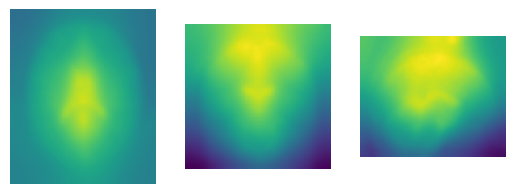

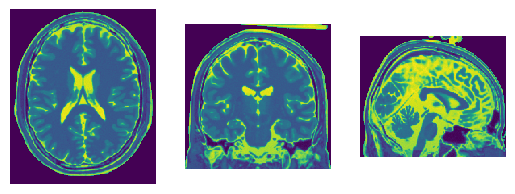

IndexError: index 2 is out of bounds for axis 1 with size 1

In [54]:
view_utils.view_center_slices([params.B], np.ones(params.B.shape,dtype=bool), color_scale=True)

brainweb_deb = lapgm.debias(brainweb_arr, params)
view_utils.view_center_slices(brainweb_deb, data_mask, color_scale=True)
view_utils.view_class_map(params.w, slice_ax=2, order=np.argsort(params.mu[:,2]) )

In [65]:
brainweb_dict_cl = brainweb_utils.download_and_read_normal(noise=0, rf_intensity=0)

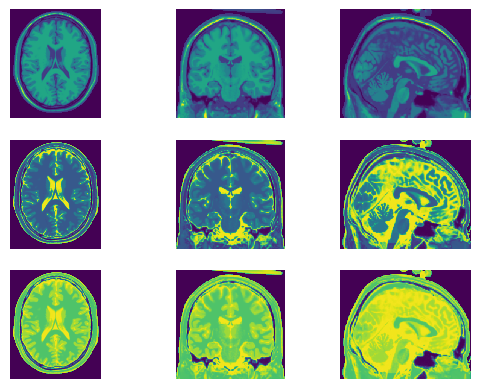

In [66]:
bias_fields = [brainweb_dict['T1'] / (brainweb_dict_cl['T1'] + 1e-12),
               brainweb_dict['T2'] / (brainweb_dict_cl['T2'] + 1e-12),
               brainweb_dict['PD'] / (brainweb_dict_cl['PD'] + 1e-12)]
view_utils.view_center_slices(brainweb_data_cl, data_mask, color_scale=True)